# Imports

In [33]:
#!pip install -U scikit-learn

In [34]:
from Transformation import Transformation
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [35]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [36]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [37]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [38]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([0.2, 0.2, 0.2])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [39]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[1.61702369 1.61796448 1.61702368 ... 1.50539459 2.18520292 1.50539459]
[1.54024635 1.54114247 1.54024634 ... 1.43391748 2.08144806 1.43391748]
[0.79743392 0.79756267 0.79743392 ... 0.78172268 0.86434199 0.78172268]
(5999,)


### Multinomial Sampling

In [40]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [41]:
target_number_point = min(len(graph._node), 48)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(51.0, -5.921278, 83.49013), (84.46553, -8.774797, 42.5), (86.072075, -0.33300498, -9.87287), (77.002495, 8.760632, 90.621), (75.0, 0.33300498, 98.79369), (80.60523, -8.672658, 89.8313), (77.13215, -6.9390492, 1.1670189), (77.39569, -6.9390492, 1.4043125), (79.47187, -7.6759295, 81.67001), (75.53198, -7.9794145, 86.26147), (75.0, -6.0434117, 1.3966535), (75.75734, -6.7292814, 95.65086), (82.54358, 8.722893, 2.6052144), (39.0, -3.0965528, 3.2371936), (91.633286, 4.0099483, 68.3), (77.75226, -0.33300498, -13.577089), (91.77941, -3.710653, 42.5), (92.03719, -3.0965528, 42.5), (76.058136, -7.9794145, 86.17813), (82.79202, 8.760632, 86.86124), (78.16764, 8.447791, -1.686517), (75.53862, 8.672658, 91.47754), (83.99175, 8.760632, 84.65161), (90.23659, 0.33300498, -4.9968486), (85.04779, -2.9401166, 95.029594), (87.44062, 0.33300498, -8.640622), (76.81164, -6.5098743, 1.562813), (39.0, -8.699333, 88.672745), (91.44655, -2.3044074, 86.54381), (87.358986, 8.048206, 42.5), (86.072075, 0.33300498

# KNN

In [42]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[51.0, -5.921278, 83.49013], [84.46553, -8.774797, 42.5], [86.072075, -0.33300498, -9.87287], [77.002495, 8.760632, 90.621], [75.0, 0.33300498, 98.79369], [80.60523, -8.672658, 89.8313], [77.13215, -6.9390492, 1.1670189], [77.39569, -6.9390492, 1.4043125], [79.47187, -7.6759295, 81.67001], [75.53198, -7.9794145, 86.26147], [75.0, -6.0434117, 1.3966535], [75.75734, -6.7292814, 95.65086], [82.54358, 8.722893, 2.6052144], [39.0, -3.0965528, 3.2371936], [91.633286, 4.0099483, 68.3], [77.75226, -0.33300498, -13.577089], [91.77941, -3.710653, 42.5], [92.03719, -3.0965528, 42.5], [76.058136, -7.9794145, 86.17813], [82.79202, 8.760632, 86.86124], [78.16764, 8.447791, -1.686517], [75.53862, 8.672658, 91.47754], [83.99175, 8.760632, 84.65161], [90.23659, 0.33300498, -4.9968486], [85.04779, -2.9401166, 95.029594], [87.44062, 0.33300498, -8.640622], [76.81164, -6.5098743, 1.562813], [39.0, -8.699333, 88.672745], [91.44655, -2.3044074, 86.54381], [87.358986, 8.048206, 42.5], [86.072075, 0.33300498

In [43]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [44]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 48
Number of edges: 550


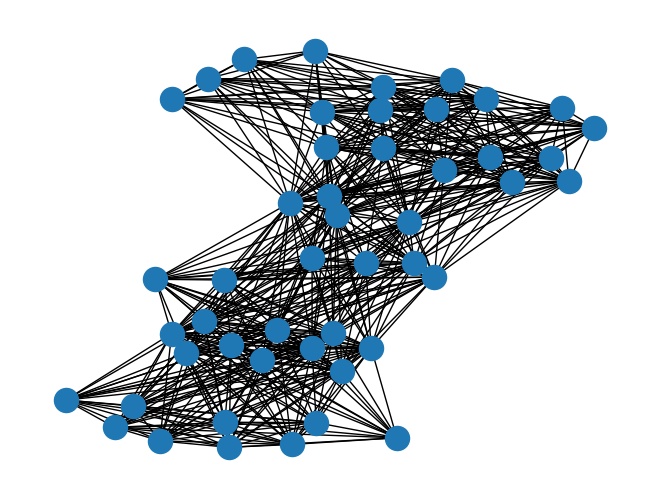

In [45]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [46]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(48, 64)


In [47]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

#construction du fi
# fi = np.random.randint(100, size=(50, 1))
# for n in range(np.size(inclusion_score,0)):
#     fi[i] = np.mean(inclusion_score[i][:])
    
# fj = np.random.randint(100, size=(50, 1))
# for m in range(np.size(inclusion_score,0)):
#     fj[i] = np.mean(inclusion_score[i][:])

f = np.random.rand(target_number_point)


# f1i = np.mean(inclusion_score)
# f1j = np.mean(inclusion_score)

S = np.random.rand(target_number_point, target_number_point)
wq = np.random.rand(64)
wk = np.random.rand(64)

In [48]:
for i in range(np.size(f,0)):
    for j in range(np.size(f, 0)): 
        f[i] = np.mean(inclusion_score[i][:])
        #print("f[",i,"] : " , f[i])
        f[j] = np.mean(inclusion_score[j][:])
        #print("f[",j,"] : " , f[j])
        wq_fi = wq*f[i].transpose()
        #print("wq_fi : " , wq_fi.transpose())
        wk_fj = wk*f[j]
        #print("wk_fj : " , wk_fj)
        wq_wk = np.matmul(wk_fj, wq_fi)
        #print("wq_wk : " , wq_wk)
        sum_wq_wk = 0
        for k in range(np.size(f, 0)):
            f[k] = np.mean(inclusion_score[k][:])
            #print("f[",k,"]",f[k])
            
            #print("wk*f[",k,"] * wq_fi = ",np.matmul(wk*f[k],wq_fi))
            #print("exp : " ,np.exp(np.matmul(wk*f[k],wq_fi))) #ça marche mais faut réduire les valeurs c'est trop grand
            sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
            #print("somme : " , sum_wq_wk)
        print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
        print("somme : ", sum_wq_wk)
        S[i][j] = np.exp(wq_wk)/sum_wq_wk
        print("S[",i,"][",j,"] :" , S[i][j])


exp(wq_wk) : 6.301270017773669e+54
somme :  8.077053807860468e+152
S[ 0 ][ 0 ] : 7.801446130817362e-99
exp(wq_wk) : 1.0574429491379113e+55
somme :  8.077053807860468e+152
S[ 0 ][ 1 ] : 1.3091938896195338e-98
exp(wq_wk) : 8.953724088860414e+74
somme :  8.077053807860468e+152
S[ 0 ][ 2 ] : 1.1085383732552065e-78
exp(wq_wk) : 5.375235926798203e+74
somme :  8.077053807860468e+152
S[ 0 ][ 3 ] : 6.654946289409517e-79
exp(wq_wk) : 1.199609088618295e+150
somme :  8.077053807860468e+152
S[ 0 ][ 4 ] : 0.0014852062610389613
exp(wq_wk) : 6.655199545513956e+85
somme :  8.077053807860468e+152
S[ 0 ][ 5 ] : 8.23963750128446e-68
exp(wq_wk) : 2.8924579252763702e+85
somme :  8.077053807860468e+152
S[ 0 ][ 6 ] : 3.581080421256416e-68
exp(wq_wk) : 3.8455084111063676e+68
somme :  8.077053807860468e+152
S[ 0 ][ 7 ] : 4.7610285910983737e-85
exp(wq_wk) : 1.1856727660243835e+152
somme :  8.077053807860468e+152
S[ 0 ][ 8 ] : 0.146795204567104
exp(wq_wk) : 1.087207266693922e+150
somme :  8.077053807860468e+152
S

C:\Users\Arthur\AppData\Local\Temp\ipykernel_9224\421861201.py:20: RuntimeWarning: overflow encountered in exp
  sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
C:\Users\Arthur\AppData\Local\Temp\ipykernel_9224\421861201.py:22: RuntimeWarning: overflow encountered in exp
  print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
C:\Users\Arthur\AppData\Local\Temp\ipykernel_9224\421861201.py:24: RuntimeWarning: overflow encountered in exp
  S[i][j] = np.exp(wq_wk)/sum_wq_wk
C:\Users\Arthur\AppData\Local\Temp\ipykernel_9224\421861201.py:24: RuntimeWarning: invalid value encountered in double_scalars
  S[i][j] = np.exp(wq_wk)/sum_wq_wk


exp(wq_wk) : 2.4234019349183655e+228
somme :  inf
S[ 4 ][ 15 ] : 0.0
exp(wq_wk) : 1.5136075645147143e+245
somme :  inf
S[ 4 ][ 16 ] : 0.0
exp(wq_wk) : 1.9930797977381174e+245
somme :  inf
S[ 4 ][ 17 ] : 0.0
exp(wq_wk) : 1.8165332724598113e+216
somme :  inf
S[ 4 ][ 18 ] : 0.0
exp(wq_wk) : 6.275218523147804e+250
somme :  inf
S[ 4 ][ 19 ] : 0.0
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 20 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 21 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 22 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 23 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 24 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 25 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 4 ][ 26 ] : nan
exp(wq_wk) : 1.7735894617008643e+239
somme :  inf
S[ 4 ][ 27 ] : 0.0
exp(wq_wk) : 8.489040234424085e+85
somme :  inf
S[ 4 ][ 28 ] : 0.0
exp(wq_wk) : 4.914179583048014e+85
somme :  inf
S[ 4 ][ 29 ] : 0.0
exp(wq_wk) : 2.7231180501836183e+231
somme :  inf
S[ 4 ][ 30 ] : 0.0
exp(wq_wk) : 3.806922456851353e+86
somme 

### Sparse Attention

# Face Candidates

#### Inputs

In [49]:
adjacency = nx.adjacency_matrix(extended_graph)
# S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  :	:
  (46, 28)	1
  (46, 29)	1
  (46, 30)	1
  (46, 31)	1
  (46, 32)	1
  (46, 33)	1
  (46, 34)	1
  (46, 35)	1
  (46, 36)	1
  (46, 37)	1
  (46, 47)	1
  (47, 21)	1
  (47, 22)	1
  (47, 23)	1
  (47, 24)	1
  (47, 25)	1
  (47, 26)	1
  (47, 27)	1
  (47, 30)	1
  (47, 32)	1
  (47, 34)	1
  (47, 35)	1
  (47, 36)	1
  (47, 37)	1
  (47, 46)	1
[[7.80144613e-099 1.30919389e-098 1.10853837e-078 ... 1.51472052e-072
  4.46286167e-089 2.82737752e-066]
 [3.10651318e-099 5.22425630e-099 5.33986137e-079 ... 7.73187052e-073
  1.94869527e-089 1.53131480e-066]
 [1.08693010e-134 2.20653913e-134 3.98032485e-107 ... 9.81454373e-099
  2.40964557e-121 3.70774924e-090]
 ...
 [1.30737501e-145 2.81243837e-145 8.63946608e-116 ... 1.03610761e-1

In [50]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[0.63312582 0.632935   0.6203053  ... 0.61760993 0.62598025 0.61523142]
 [0.632935   0.63274368 0.620077   ... 0.61737243 0.62576969 0.61498535]
 [0.6203053  0.620077   0.60460922 ... 0.60119846 0.61165382 0.5981493 ]
 ...
 [0.61760993 0.61737243 0.60119846 ... 0.59760678 0.60858627 0.59438707]
 [0.62598025 0.62576969 0.61165382 ... 0.60858627 0.61804397 0.60585965]
 [0.61523142 0.61498535 0.5981493  ... 0.59438707 0.60585965 0.59100627]]
(48, 48)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [51]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (39.0, -6.8353896, 84.457664)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (39.0, -8.699333, 88.672745)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (75.48362, -5.0095077, 82.68843)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (75.53198, -7.9794145, 86.26147)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (76.058136, -7.9794145, 86.17813)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (75.75734, -6.7292814, 95.65086)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (79.26829, -7.9794145, 83.971855)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (79.47187, -7.6759295, 81.67001)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (75.0, 0.33300498, 98.79369)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), (75.53862, 8.672658, 91.47754)], [(51.0, -5.921278, 83.49013), (51.0, -6.3966537, 83.95659), 

In [52]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[0.6244391  0.62450939        nan ... 0.63523282 0.63547325 0.59532719]


#### Calculate barycenter

In [53]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[47.0, -6.384440739949544, 83.96812947591145], [47.0, -7.005755106608073, 85.37314860026042], [59.16120402018229, -5.7758134206136065, 83.37838236490886], [59.177327473958336, -6.7657820383707685, 84.56939697265625], [59.35271199544271, -6.7657820383707685, 84.54161580403645], [59.25244649251302, -6.349071502685547, 87.69919840494792], [60.422760009765625, -6.7657820383707685, 83.80619303385417], [60.490620930989586, -6.664620717366536, 83.03890991210938], [59.0, -3.994975725809733, 88.74680582682292], [59.1795399983724, -1.215091387430827, 86.30808512369792], [59.306050618489586, -3.7736082077026367, 88.72200520833333], [60.868408203125, -6.996863047281901, 85.75933837890625], [59.667500813802086, -1.1857668558756511, 86.02257283528645], [43.0, -7.152000427246094, 85.54018147786458], [55.16120402018229, -5.922058741251628, 83.54540506998698], [55.177327473958336, -6.912027359008789, 84.73641967773438], [55.35271199544271, -6.912027359008789, 84.70863850911458], [55.25244649251302, -6

In [54]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [55]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(47.0, -6.384440739949544, 83.96812947591145): {'index_poly': {0, 1, 169, 13, 91}}, (47.0, -7.005755106608073, 85.37314860026042): {'index_poly': {0, 1, 169, 170, 13, 91}}, (43.0, -7.152000427246094, 85.54018147786458): {'index_poly': {0, 1, 91, 13}}, (51.16120402018229, -6.848077138264974, 85.27294413248698): {'index_poly': {0, 1, 169, 170, 171, 172, 13, 173, 174, 178, 91}}, (43.0, -7.310459136962891, 85.69565836588542): {'index_poly': {0, 1, 91, 13}}, (51.177327473958336, -7.838045756022136, 86.46395874023438): {'index_poly': {0, 1, 169, 170, 171, 172, 13, 173, 174, 175, 177, 178, 91}}, (51.35271199544271, -7.838045756022136, 86.43617757161458): {'index_poly': {0, 1, 169, 170, 171, 172, 13, 173, 174, 175, 178, 91}}, (52.490620930989586, -7.736884435017903, 84.9334716796875): {'index_poly': {0, 1, 169, 170, 171, 172, 13, 173, 174, 178, 91}}, (52.422760009765625, -7.838045756022136, 85.7007548014323): {'index_poly': {0, 1, 169, 170, 171, 172, 13, 173, 174, 178, 91}}, (51.2524464925130

In [56]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 3333
Number of edges: 84304


#### calculate e norm matrix

In [57]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[0.66600907, 12.073596, 12.018468], [0.66600907, 13.363275, 13.097498], [0.66600907, 24.513702, 24.555653], [0.66600907, 24.773663, 24.690804], [0.66600907, 25.285795, 25.20616], [0.66600907, 27.594604, 27.382341], [0.66600907, 28.347204, 28.312567], [0.66600907, 28.583895, 28.592175], [0.66600907, 29.143013, 29.007378], [0.66600907, 29.646679, 29.76227], [0.66600907, 30.011751, 29.891787], [0.66600907, 30.401485, 30.268171], [0.66600907, 30.700775, 30.826733], [12.073596, 13.363275, 4.608816], [12.073596, 24.513702, 36.5721], [12.073596, 24.773663, 36.594376], [12.073596, 25.285795, 37.11569], [12.073596, 27.594604, 38.423965], [12.073596, 28.347204, 40.287464], [12.073596, 28.583895, 40.57647], [12.073596, 29.143013, 39.406948], [12.073596, 29.646679, 40.309414], [12.073596, 30.011751, 40.344654], [12.073596, 30.401485, 41.991035], [12.073596, 30.700775, 41.538082], [13.363275, 24.513702, 37.15483], [13.363275, 24.773663, 36.61855], [13.363275, 25.285795, 37.148983], [13.363275, 27.

#### Calculate r

In [58]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

max_diff_vectors = np.array(diff_vectors).max(axis=1)
min_diff_vectors = np.array(diff_vectors).min(axis=1)

barycenters_numpy = np.array(barycenters)

# Calculate differences once to avoid redundant computations
diff_vectors = min_diff_vectors[:, np.newaxis] - min_diff_vectors
max_diff_vectors_diff = max_diff_vectors[:, np.newaxis] - max_diff_vectors
barycenters_diff = barycenters_numpy[:, np.newaxis, :] - barycenters_numpy

# Populate the r_matrix using vectorized operations
r_matrix = np.stack([diff_vectors, max_diff_vectors_diff, barycenters_diff[:, :, 0], barycenters_diff[:, :, 1], barycenters_diff[:, :, 2]], axis=-1)

print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

(3333, 3333, 5)


#### Calculate f

In [59]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

nan
(3333,)
[nan nan nan ... nan nan nan]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_9224\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [60]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(48, 3, 3)


In [61]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [62]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(79.26829, -7.9794145, 83.971855): {'index_triangle': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}}, (80.60523, -8.672658, 89.8313): {'index_triangle': {0, 33, 3, 5, 6, 7, 9, 10, 43, 21}}, (91.44655, -2.3044074, 86.54381): {'index_triangle': {0, 34, 12, 45, 47, 24}}, (77.002495, 8.760632, 90.621): {'index_triangle': {32, 1, 2, 4, 8, 10, 11, 12, 42}}, (81.66343, 8.798424, 87.19978): {'index_triangle': {1, 6, 41, 47, 31}}, (90.01186, 3.5589852, 88.84892): {'index_triangle': {2, 3, 37, 47, 27}}, (85.04779, -2.9401166, 95.029594): {'index_triangle': {4, 36, 21, 23, 26}}, (82.79202, 8.760632, 86.86124): {'index_triangle': {40, 5, 30}}, (87.52066, -3.5589852, 92.47365): {'index_triangle': {35, 7, 11, 46, 25}}, (83.77167, 0.99710757, 96.39297): {'index_triangle': {8, 9, 28, 38}}, (84.46553, -8.774797, 42.5): {'index_triangle': {13, 14, 15, 16, 17, 18, 19, 20, 

In [63]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 24
Number of edges: 73


In [64]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)